# 数据科学大作业

In [25]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

from sklearn.model_selection import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.decomposition import PCA

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import seaborn as sns
from math import ceil

import random
import pickle
import time

np.random.seed(666)
random_seed = 666

## 1. 读取数据 & 数据清理

### 1.1 数据读取

In [2]:
df = pd.read_csv('adult.txt')
df.columns = [
    "age", "work_class", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]
print(df.sample(5, random_state=666))

       age work_class  fnlwgt      education  education_num  marital_status  \
37391   36    Private  228652   Some-college             10        Divorced   
23684   24    Private  249046      Bachelors             13   Never-married   
47602   55    Private  173832        Masters             14        Divorced   
3192    71    Private  157909   Some-college             10   Never-married   
22276   39    Private   98776   Some-college             10        Divorced   

               occupation    relationship    race      sex  capital_gain  \
37391   Machine-op-inspct       Own-child   Other     Male             0   
23684        Tech-support       Own-child   White     Male             0   
47602               Sales   Not-in-family   White     Male         10520   
3192        Other-service   Not-in-family   White   Female          2964   
22276     Exec-managerial   Not-in-family   White     Male             0   

       capital_loss  hours_per_week  native_country   income  
37391

### 1.2 数据清理

In [3]:
with open('adult.txt', 'r') as f:
    raw_data = f.readlines()[1:]
    data = []

    for line in raw_data:
        line = line.strip().rstrip(',')
        data.append(line.split(', '))

#print(random.sample(data, 100))
miss = [0] * 5
del_list = []
for i, d in enumerate(data):
    nan = d.count('?')
    if nan > 0:
        del_list.append(i)
        miss[nan] += 1

print(miss)
print(len(del_list))

[0, 821, 2753, 46, 0]
3620


In [6]:
real_data = []
for i, d in enumerate(data):
    if not i in del_list:
        real_data.append(d)
    
print(len(real_data))
with open('real_data.pkl', 'wb') as f:
    pickle.dump(real_data, f)
# for i, d in enumerate(real_data):
#     nan = d.count('?')
#     if nan > 0:
#         print(d)

45222


## 2. 探索各特征的分布

In [21]:
with open('real_data.pkl', 'rb') as f:
    real_data = pickle.load(f)
real_df = pd.DataFrame(real_data, dtype=np.int32)
class_list = [
    "age", "work_class", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]
real_df.columns = class_list

num_feature = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
class_feature = ["work_class", "education", "marital_status", "occupation", "relationship", "race", "sex",
    "native_country", "income"
]


,age,work_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


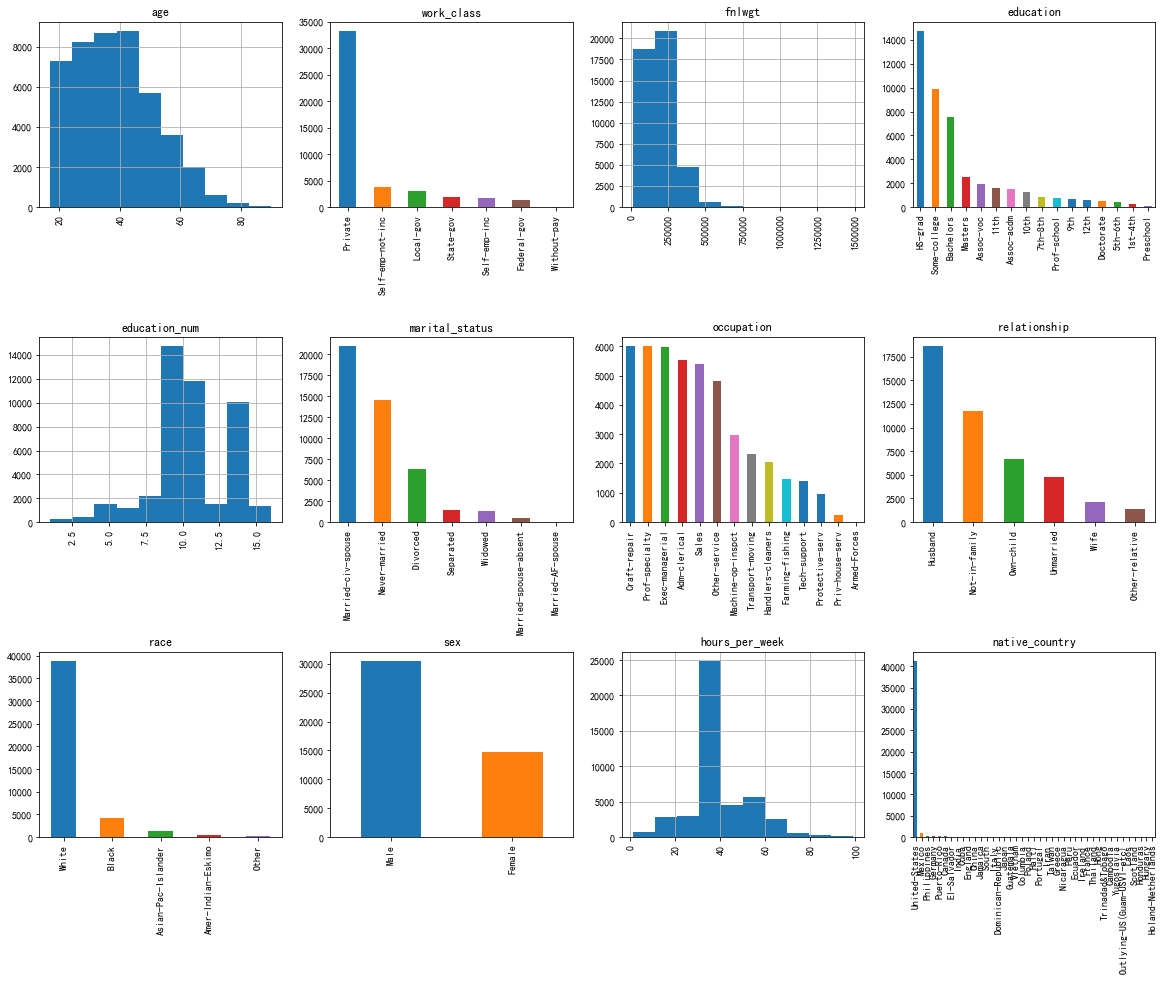

In [22]:
real_df = real_df.drop('income', axis=1)
real_df = real_df.drop('capital_gain', axis=1)
real_df = real_df.drop('capital_loss', axis=1)

fig = plt.figure(figsize=(20,15))
cols = 4
rows = ceil(float(real_df.shape[1]) / cols)
for i, column in enumerate(real_df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if real_df.dtypes[column] == np.object:
        if column == 'age':
            real_df[column].value_counts(bins=10).plot(kind="bar", axes=ax)
        elif column == 'fnlwgt':
            real_df[column].value_counts(bins=10).plot(kind="bar", axes=ax)
        elif column == 'hours_per_week':
            real_df[column].value_counts(bins=10).plot(kind="bar", axes=ax)
        else:
            real_df[column].value_counts().plot(kind="bar", axes=ax)
    else:
        real_df[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.savefig('report/img/all_features')
plt.show()

### 2.1 数值特征的数值特征

In [3]:
num_real_df = pd.DataFrame(real_df[num_feature], dtype=np.int32)
num_real_df.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,45222.000000,4.522200e+04,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,1.897347e+05,10.118460,1101.430344,88.595418,40.938017
std,13.217870,1.056392e+05,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.173882e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783160e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.379260e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


### 2.2 数值特征的分布图

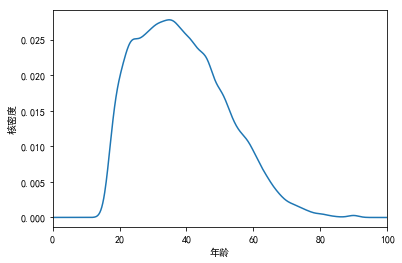

In [4]:
tar_df = num_real_df['age']
plt.figure(figsize=(6, 4))
tar_df.plot(kind='kde')

plt.xlabel(u'年龄')
plt.ylabel(u'核密度')
plt.xlim((0, 100))
plt.savefig('report/img/age_dis.pdf')
plt.show()

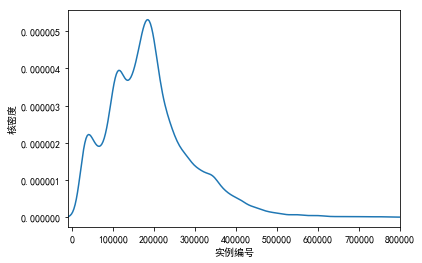

In [16]:
tar_df = num_real_df['fnlwgt']
plt.figure(figsize=(6, 4))
tar_df.plot(kind='kde')

plt.xlabel(u'实例编号')
plt.ylabel(u'核密度')
plt.xlim((-10000, 800000))
plt.subplots_adjust(left=0.16, right=0.93)
plt.savefig('report/img/fnlwgt_dis.pdf')
plt.show()

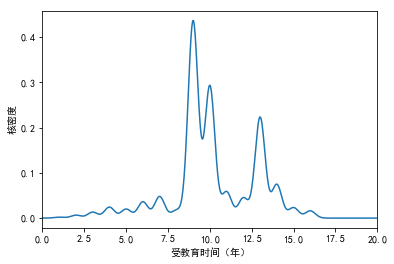

In [6]:
tar_df = num_real_df['education_num']
plt.figure(figsize=(6, 4))
tar_df.plot(kind='kde')

plt.xlabel(u'受教育时间（年）')
plt.ylabel(u'核密度')
plt.xlim((0, 20))
plt.savefig('report/img/edu_num_dis.pdf')
plt.show()

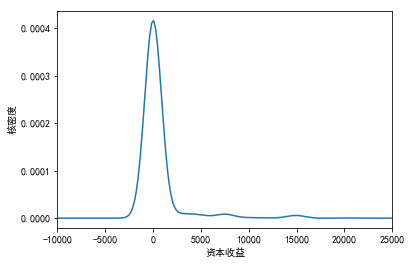

In [7]:
tar_df = num_real_df['capital_gain']
plt.figure(figsize=(6, 4))
tar_df.plot(kind='kde')

plt.xlabel(u'资本收益')
plt.ylabel(u'核密度')
plt.xlim((-10000, 25000))
plt.savefig('report/img/cap_in_dis.pdf')
plt.show()

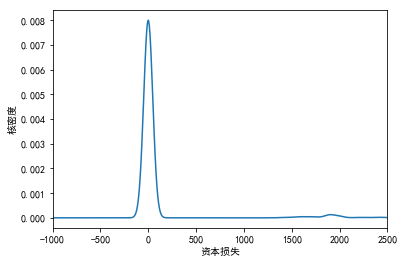

In [8]:
tar_df = num_real_df['capital_loss']
plt.figure(figsize=(6, 4))
tar_df.plot(kind='kde')

plt.xlabel(u'资本损失')
plt.ylabel(u'核密度')
plt.xlim((-1000, 2500))
plt.savefig('report/img/cap_out_dis.pdf')
plt.show()

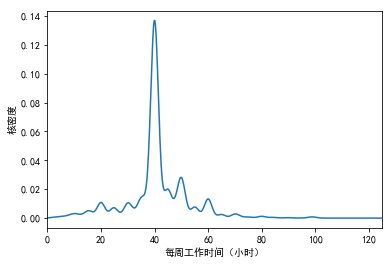

In [19]:
tar_df = num_real_df['hours_per_week']
plt.figure(figsize=(6, 4))
tar_df.plot(kind='kde')

plt.xlabel(u'每周工作时间（小时）')
plt.ylabel(u'核密度')
plt.xlim((0, 125))
plt.savefig('report/img/hours_per_week_dis.pdf')
plt.show()

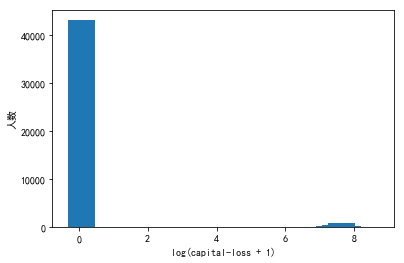

In [24]:
log_capital_loss = np.log(num_real_df.capital_loss + 1)
hist, bins = np.histogram(log_capital_loss, bins=50)

plt.figure(figsize=(6, 4))
plt.bar((bins[:-1] + bins[1:]) / 2, hist, align="center",)
plt.xlabel("log(capital-loss + 1)")
plt.ylabel(u'人数')

plt.subplots_adjust(left=0.14, right=0.93)
plt.savefig('report/img/cap-out-hist.pdf')
plt.show()

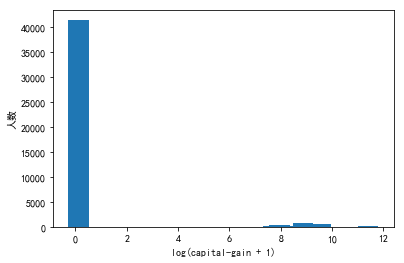

In [28]:
log_capital_loss = np.log(num_real_df.capital_gain + 1)
hist, bins = np.histogram(log_capital_loss, bins=50)

plt.figure(figsize=(6, 4))
plt.bar((bins[:-1] + bins[1:]) / 2, hist, align="center",)
plt.xlabel("log(capital-gain + 1)")
plt.ylabel(u'人数')

plt.subplots_adjust(left=0.14, right=0.93)
plt.savefig('report/img/cap-in-hist.pdf')
plt.show()

### 2.3 类别数据的分布

In [4]:
class_real_df = real_df[class_feature]
class_real_df.describe()

,work_class,education,marital_status,occupation,relationship,race,sex,native_country,income
count,45222,45222,45222,45222,45222,45222,45222,45222,45222
unique,7,16,7,14,6,5,2,41,4
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K
freq,33307,14783,21055,6020,18666,38903,30527,41292,22654


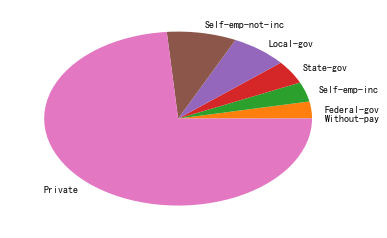

In [10]:
tar_df = class_real_df['work_class']
plt.figure(figsize=(6, 4))
tar_df.value_counts(ascending=True).plot(kind='pie', label='')

plt.savefig('report/img/work_class_dis.pdf')
plt.show()

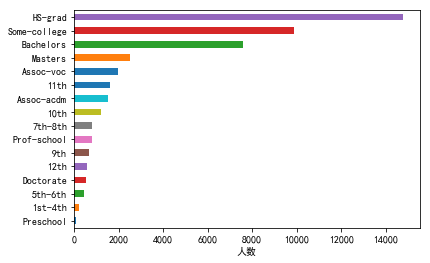

In [13]:
tar_df = class_real_df['education']
plt.figure(figsize=(6, 4))
tar_df.value_counts(ascending=True).plot(kind='barh')

plt.xlabel(u'人数')
plt.subplots_adjust(left=0.17, right=0.97)
plt.savefig('report/img/edu_dis.pdf')
plt.show()

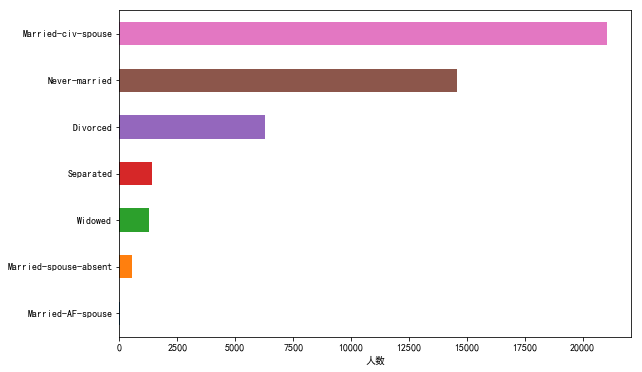

In [30]:
tar_df = class_real_df['marital_status']
plt.figure(figsize=(9, 6))
tar_df.value_counts(ascending=True).plot(kind='barh')

plt.xlabel(u'人数')
plt.subplots_adjust(left=0.18, right=0.97)
plt.savefig('report/img/marry_dis.pdf')
plt.show()

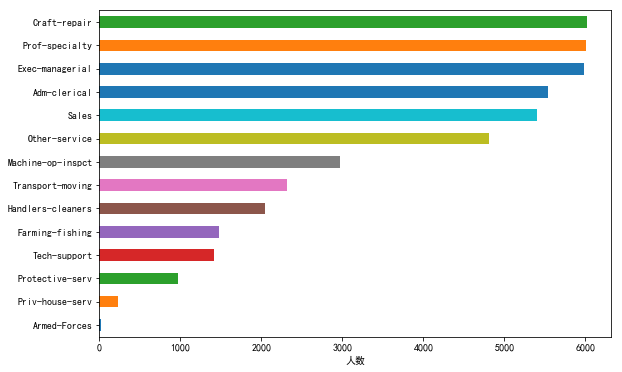

In [26]:
tar_df = class_real_df['occupation']
plt.figure(figsize=(9, 6))
tar_df.value_counts(ascending=True).plot(kind='barh')

plt.xlabel(u'人数')
plt.subplots_adjust(left=0.18, right=0.97)
plt.savefig('report/img/occupation_dis.pdf')
plt.show()

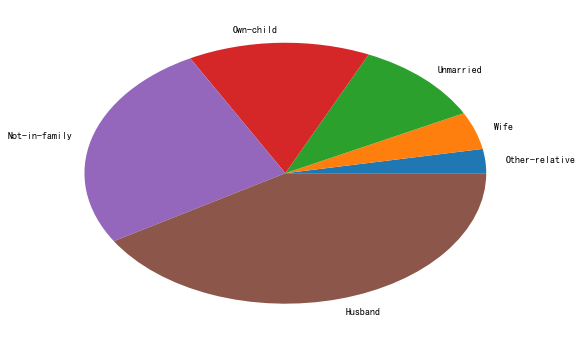

In [14]:
tar_df = class_real_df['relationship']
plt.figure(figsize=(9, 6))
tar_df.value_counts(ascending=True).plot(kind='pie', label='')

plt.savefig('report/img/relationship_dis.pdf')
plt.show()

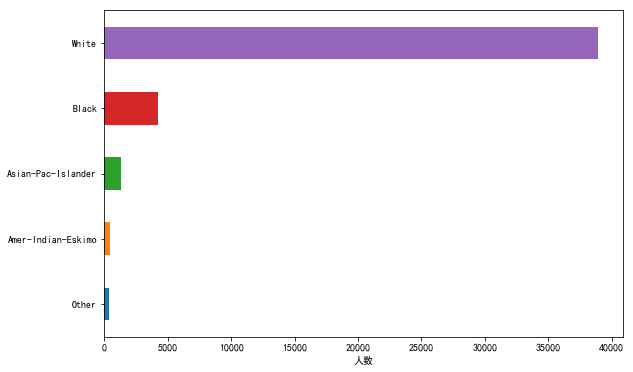

In [13]:
tar_df = class_real_df['race']
plt.figure(figsize=(9, 6))
tar_df.value_counts(ascending=True).plot(kind='barh')

plt.xlabel(u'人数')
plt.subplots_adjust(left=0.17, right=0.97)
plt.savefig('report/img/race_dis.pdf')
plt.show()

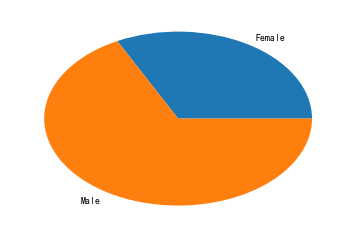

In [11]:
tar_df = class_real_df['sex']
plt.figure(figsize=(6, 4))
tar_df.value_counts(ascending=True).plot(kind='pie', label='')

plt.savefig('report/img/sex_dis.pdf')
plt.show()

['United-States', 'Cuba', 'Jamaica', 'India', 'Mexico', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany', 'Iran', 'Philippines', 'Poland', 'Columbia', 'Cambodia', 'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal', 'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala', 'Italy', 'China', 'South', 'Japan', 'Yugoslavia', 'Peru', 'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago', 'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary', 'Holand-Netherlands']


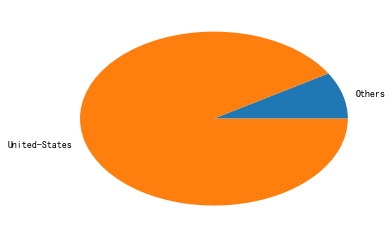

In [21]:
tar_df = class_real_df['native_country']
all_country = list(class_real_df['native_country'].unique())
print(all_country)
all_country.remove('United-States')

tar_df2 = tar_df
for country in all_country:
    tar_df2 = tar_df2.replace(country, 'Others')
tar_df2

#plt.figure(figsize=(10, 15))
plt.figure(figsize=(6, 4))
tar_df2.value_counts(ascending=True).plot(kind='pie', label='')

plt.savefig('report/img/native_country_dis.pdf')
plt.show()

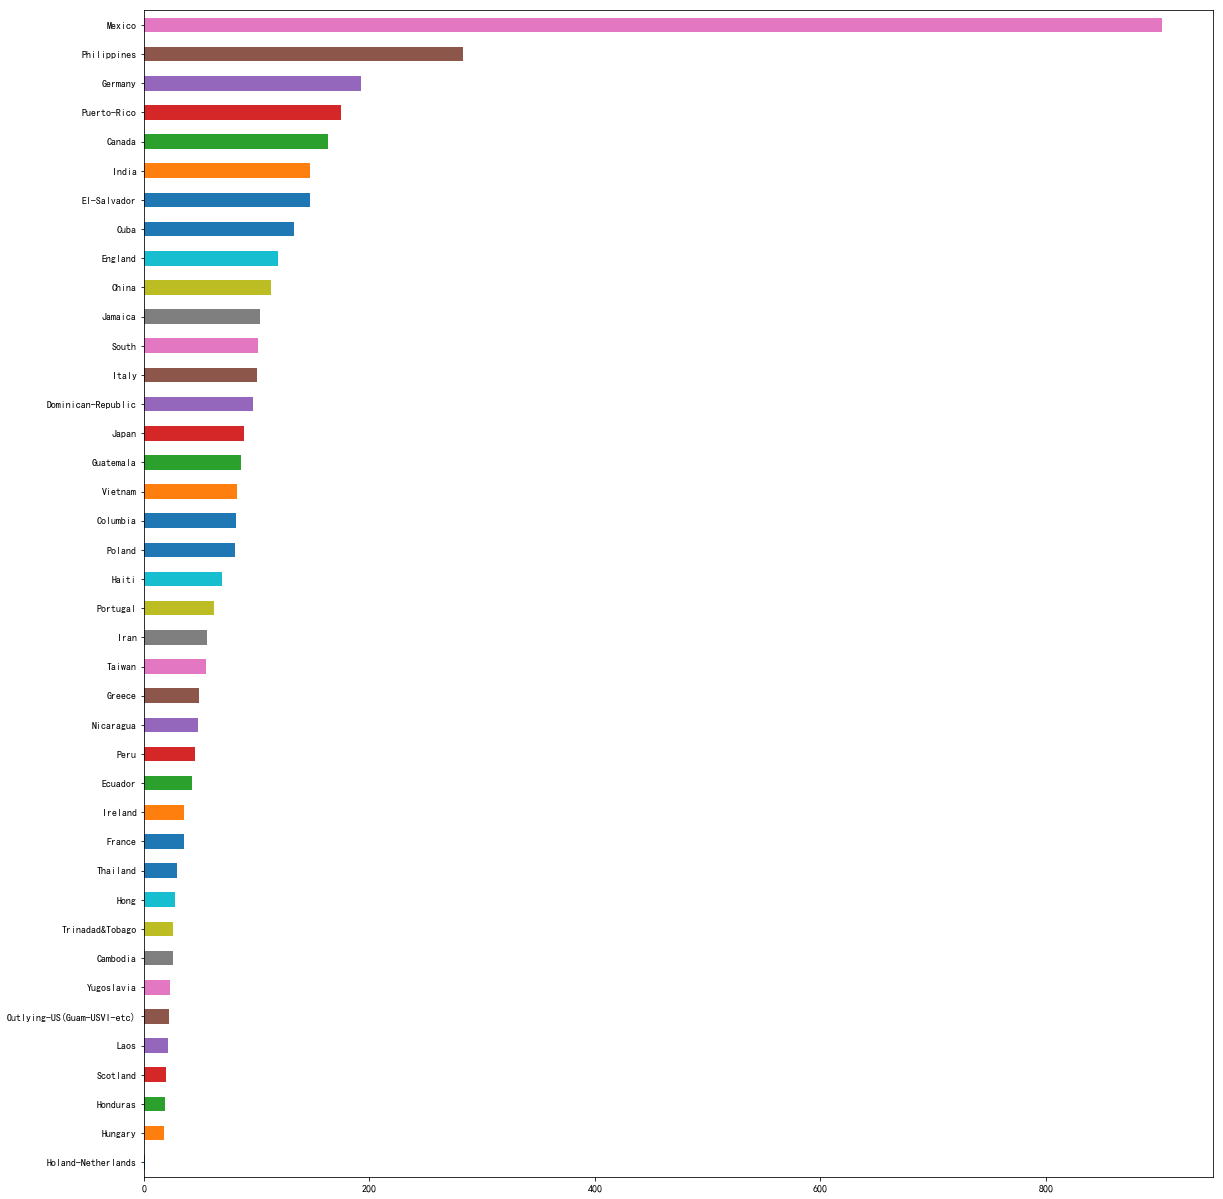

In [18]:
tar_df = class_real_df[class_real_df['native_country'] != 'United-States']['native_country']

plt.figure(figsize=(18, 18))
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.125, right=0.95)
tar_df.value_counts(ascending=True).plot(kind='barh')

plt.savefig('report/img/native_country_dis2.pdf')
plt.show()

# 3. 计算各特征的相关性

In [23]:
with open('real_data.pkl', 'rb') as f:
    real_data = pickle.load(f)
real_df = pd.DataFrame(real_data)
class_list = [
    "age", "work_class", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]
real_df.columns = class_list

num_feature = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
class_feature = ["work_class", "education", "marital_status", "occupation", "relationship", "race", "sex",
    "native_country", "income"
]

real_df = real_df.drop('income', axis=1)

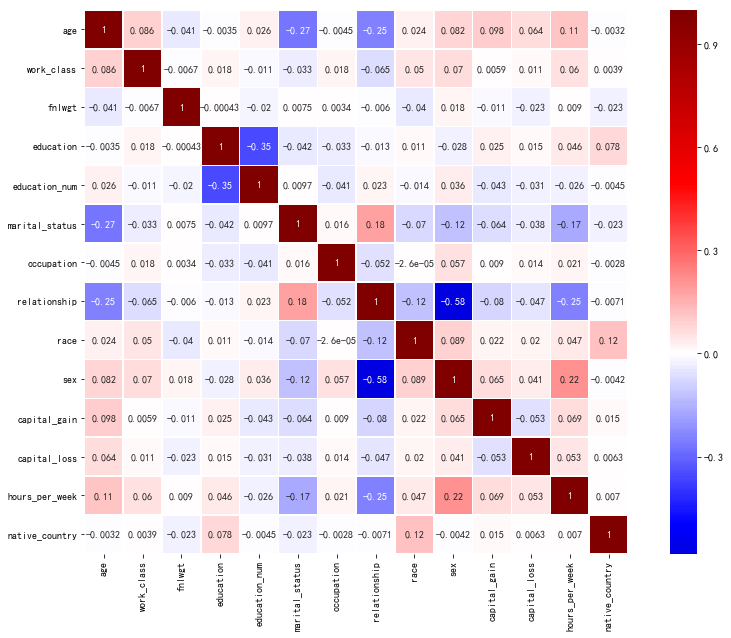

In [43]:
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

# Calculate the correlation and plot it
f, ax = plt.subplots(figsize=(15, 10))
encoded_data, _ = number_encode_features(real_df)
sns.heatmap(encoded_data.corr(), square=True, linewidths=.5, center = 0, cmap='seismic', annot=True)
plt.savefig('report/img/cof_heat_anno')
plt.show()

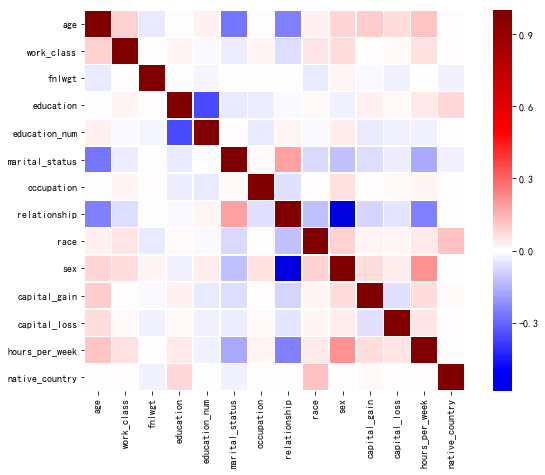

In [46]:
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

# Calculate the correlation and plot it
f, ax = plt.subplots(figsize=(10, 7))
encoded_data, _ = number_encode_features(real_df)
sns.heatmap(encoded_data.corr(), square=True, linewidths=.5, center = 0, cmap='seismic')
plt.savefig('report/img/cof_heat')
plt.show()

In [ ]:
# calculate correlation parameters
print(encoded_data)

real_np = encoded_data.data
with open('cof.txt', 'w') as f:
    for i in range(real_np.shape[1]):
        f.write('%d & ' % i+1)
        char_data = real_np[:, i]

        # corr among characters
        for j in range(self.data.shape[1]):
            self.corr_sheet.write(j + 1, i + 1, np.corrcoef(char_data, self.data[:, j])[0][1])

        # corr between characters and target
        self.corr_sheet.write(j + 2, i + 1, np.corrcoef(char_data, self.target)[0][1])

# 4. 数据预处理

## 4.1 向量化

In [46]:
# read data
with open('real_data.pkl', 'rb') as f:
    real_data = pickle.load(f)
real_df = pd.DataFrame(real_data)

class_list = [
    "age", "work_class", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]
real_df.columns = class_list
target = real_df['income'].map({ "<=50K": -1, "<=50K.": -1, ">50K": 1, ">50K.": -1 })
print(pd.value_counts(real_df['income']))
real_df = real_df.drop('income', axis=1)

# save the target as .npy
print(target.values.shape)
np.save('adult_y.npy', target.values)

num_feature = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
class_feature = ["work_class", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]

# vectorize and save the features as .npy
vec_df = pd.DataFrame(pd.get_dummies(real_df, columns=class_feature), dtype=np.int32)
np.save('adult_x.npy', vec_df.values)

<=50K     22654
<=50K.    11360
>50K       7508
>50K.      3700
Name: income, dtype: int64
(45222,)


# 5. 分类

In [89]:
def norm(data):
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler.transform(data)

# load data
X = np.load('adult_x.npy')
Y = np.load('adult_y.npy')

x_tr = np.load('adult_x_tr.npy')
x_t = np.load('adult_x_t.npy')
y_tr = np.load('adult_y_tr.npy')
y_t = np.load('adult_y_t.npy')

# x_tr, x_t, y_tr, y_t = train_test_split(X, Y, test_size=0.2, random_state=random_seed)

# np.save('adult_x_tr.npy', x_tr)
# np.save('adult_x_t.npy', x_t)
# np.save('adult_y_tr.npy', y_tr)
# np.save('adult_y_t.npy', y_t)

# 5.1 baseline

In [3]:
def DT(x, y, x_t, y_t):
    model = DecisionTreeClassifier(random_state=random_seed)
    model.fit(x, y)
    y_pre = model.predict(x_t)
    print(classification_report(y_t, y_pre))
    return precision_score(y_t, y_pre, average='micro'), accuracy_score(y_t, y_pre), f1_score(y_t, y_pre, average='micro')
    
def SVM(x, y, x_t, y_t):
    model = SVC(random_state=random_seed)
    model.fit(x, y)
    y_pre = model.predict(x_t)
    print(classification_report(y_t, y_pre))
    return precision_score(y_t, y_pre, average='micro'), accuracy_score(y_t, y_pre), f1_score(y_t, y_pre, average='micro')
    
def MLP(x, y, x_t, y_t):
    model = MLPClassifier(random_state=random_seed)
    model.fit(x, y)
    y_pre = model.predict(x_t)
    print(classification_report(y_t, y_pre))
    return precision_score(y_t, y_pre, average='micro'), accuracy_score(y_t, y_pre), f1_score(y_t, y_pre, average='micro')
    
def NULL(x, y, x_t, y_t):
    y_pre = np.random.random(y_t.shape)
    y_pre[np.where(y_pre>0.5)] = 1
    y_pre[np.where(y_pre<=0.5)] = -1
    print(classification_report(y_t, y_pre))
    return precision_score(y_t, y_pre, average='micro'), accuracy_score(y_t, y_pre), f1_score(y_t, y_pre, average='micro')

In [4]:
# split dataset 0.8-0.2
x, x_t, y, y_t = train_test_split(X, Y, test_size=0.2, random_state=random_seed)

t = time.time()
SVM(x, y, x_t, y_t)
print('used time: ', time.time() - t)

             precision    recall  f1-score   support

         -1       0.83      0.99      0.91      7520
          1       0.39      0.03      0.06      1525

avg / total       0.76      0.83      0.76      9045

used time:  1044.2209346294403


In [13]:
# 5-fold cv
skfolds = StratifiedKFold(Y, n_folds=5)

pre, acc, f1 = [], [], []
t = time.time()
for train,test in skfolds:
    x, y, x_t, y_t = X[train], Y[train], X[test], Y[test]
    p, a, f = SVM(x, y, x_t, y_t)
    pre.append(p)
    acc.append(a)
    f1.append(f)

print('used time: ', time.time() - t)
print('avg precision: ', np.array(pre).mean())
print('avg accuracy: ', np.array(acc).mean())
print('avg f1-score: ', np.array(f1).mean())

             precision    recall  f1-score   support

         -1       0.84      0.99      0.91      7543
          1       0.34      0.02      0.05      1502

avg / total       0.75      0.83      0.76      9045

             precision    recall  f1-score   support

         -1       0.84      0.99      0.91      7543
          1       0.42      0.03      0.06      1502

avg / total       0.77      0.83      0.77      9045

             precision    recall  f1-score   support

         -1       0.84      0.99      0.91      7543
          1       0.41      0.03      0.05      1502

avg / total       0.77      0.83      0.77      9045

             precision    recall  f1-score   support

         -1       0.84      0.99      0.91      7543
          1       0.30      0.03      0.05      1501

avg / total       0.75      0.83      0.76      9044

             precision    recall  f1-score   support

         -1       0.84      0.99      0.91      7542
          1       0.30      0.02 

## 5.2 决策树

In [10]:
model = DecisionTreeClassifier(random_state=random_seed)
param_grid = {'criterion': ['gini', 'entropy'],
              'max_features': ['sqrt', 'log2', None],
              'max_depth': list(range(5, 10)),
              'presort': [True, False],
              'splitter': ['best', 'random']
              }

grid = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted')
grid.fit(X, Y)

print(grid.best_params_)
print(grid.best_score_)

export_graphviz(grid.best_estimator_, filled=True, out_file='report/img/gs.dot')

d:\1\anaconda3\envs\labelme2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\1\anaconda3\envs\labelme2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\1\anaconda3\envs\labelme2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\1\anaconda3\envs\labelme2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\1\anaconda3\envs\labelme2\lib\site-packag

{'criterion': 'entropy', 'splitter': 'best', 'max_features': None, 'max_depth': 9, 'presort': True}
0.8323175988145577


## 5.3 SVM

In [ ]:
interval = 150
max_iter = 3000
res_tr = []
res_t = []

# training stage
for i in range(interval, max_iter + 1, interval):
#     model = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#             decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
#             max_iter=i, probability=False, shrinking=True,
#             tol=0.001, verbose=False, random_state=random_seed)
    model = SVC(kernel='poly', max_iter=i, random_state=random_seed)
    model.fit(x_tr, y_tr)

    y_pre_tr = model.predict(x_tr)
    y_pre_t = model.predict(x_t)
    
    res_tr.append(round(f1_score(y_tr, y_pre_tr, average='micro'), 3))
    res_t.append(round(f1_score(y_t, y_pre_t, average='micro'), 3))

print('train: ', res_tr)
print('test: ', res_t)

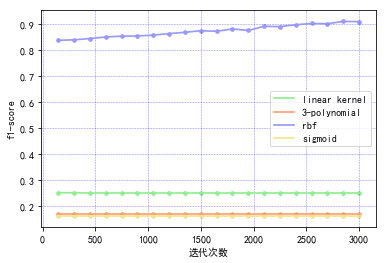

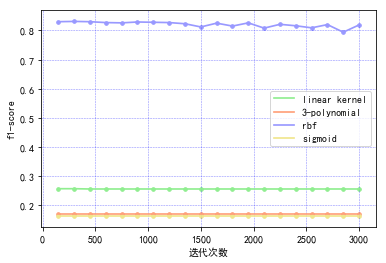

In [65]:
# SVM kernel (no norm)

x = list(range(interval, max_iter + 1, interval))
y_tr_linear = [0.25, 0.25, 0.249, 0.249, 0.249, 0.249, 0.249, 0.249, 0.249, 0.249, 0.249, 0.249, 0.249, 0.249, 0.249, 0.249, 0.249, 0.249, 0.249, 0.249]
y_tr_poly3 = [0.166, 0.166, 0.166, 0.166, 0.166, 0.166, 0.166, 0.166, 0.166, 0.166, 0.166, 0.166, 0.166, 0.166, 0.166, 0.166, 0.166, 0.166, 0.166, 0.166]
y_tr_rbf = [0.838, 0.84, 0.845, 0.851, 0.854, 0.855, 0.858, 0.864, 0.869, 0.875, 0.873, 0.882, 0.876, 0.892, 0.891, 0.898, 0.903, 0.902, 0.911, 0.91]
y_tr_sigmoid = [0.162] * 20
y_t_linear = [0.257, 0.257, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256, 0.256]
y_t_poly3 = [0.169] * 20
y_t_rbf = [0.83, 0.831, 0.83, 0.827, 0.826, 0.829, 0.828, 0.827, 0.823, 0.812, 0.825, 0.815, 0.826, 0.808, 0.821, 0.816, 0.809, 0.82, 0.794, 0.819]
y_t_sigmoid = [0.165] * 20

plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.plot(x, y_tr_linear, color='#90EE90', linewidth=1.7, label='linear kernel')
ax.plot(x, y_tr_poly3, color='#ffa07a', linewidth=1.7, label='3-polynomial')
ax.plot(x, y_tr_rbf, color='#9999ff', linewidth=1.7, label='rbf')
ax.plot(x, y_tr_sigmoid, color='#F0E68C', linewidth=1.7, label='sigmoid')
ax.scatter(x, y_tr_linear, s=13, c='#90EE90')
ax.scatter(x, y_tr_poly3, s=13, c='#ffa07a')
ax.scatter(x, y_tr_rbf, s=13, c='#9999ff')
ax.scatter(x, y_tr_sigmoid, s=13, c='#F0E68C')
ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.xlabel('迭代次数')
plt.ylabel('f1-score')
plt.legend()
plt.savefig('report/img/svm_kernel_tr.png')
plt.show()

plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.plot(x, y_t_linear, color='#90EE90', linewidth=1.7, label='linear kernel')
ax.plot(x, y_t_poly3, color='#ffa07a', linewidth=1.7, label='3-polynomial')
ax.plot(x, y_t_rbf, color='#9999ff', linewidth=1.7, label='rbf')
ax.plot(x, y_t_sigmoid, color='#F0E68C', linewidth=1.7, label='sigmoid')
ax.scatter(x, y_t_linear, s=13, c='#90EE90')
ax.scatter(x, y_t_poly3, s=13, c='#ffa07a')
ax.scatter(x, y_t_rbf, s=13, c='#9999ff')
ax.scatter(x, y_t_sigmoid, s=13, c='#F0E68C')
ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.xlabel('迭代次数')
plt.ylabel('f1-score')
plt.legend()
plt.savefig('report/img/svm_kernel_t.png')
plt.show()


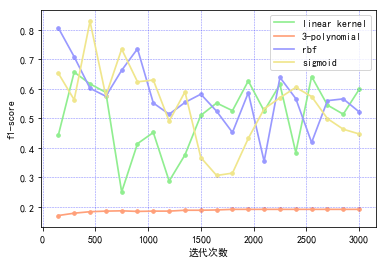

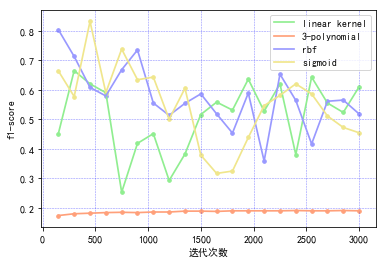

In [64]:
# SVM kernel (norm)
interval = 150
max_iter = 3000
x = list(range(interval, max_iter + 1, interval))
y_tr_linear =  [0.443, 0.657, 0.617, 0.588, 0.25, 0.414, 0.452, 0.287, 0.376, 0.51, 0.552, 0.526, 0.627, 0.525, 0.615, 0.384, 0.642, 0.545, 0.514, 0.598]
y_tr_poly3 = [0.17, 0.178, 0.183, 0.185, 0.186, 0.184, 0.185, 0.185, 0.188, 0.188, 0.189, 0.191, 0.191, 0.191, 0.191, 0.191, 0.191, 0.191, 0.191, 0.191]
y_tr_rbf = [0.807, 0.709, 0.602, 0.575, 0.663, 0.736, 0.552, 0.514, 0.554, 0.582, 0.524, 0.452, 0.587, 0.354, 0.639, 0.567, 0.418, 0.56, 0.566, 0.522]
y_tr_sigmoid = [0.653, 0.563, 0.829, 0.576, 0.735, 0.624, 0.63, 0.49, 0.59, 0.367, 0.306, 0.314, 0.432, 0.532, 0.57, 0.605, 0.574, 0.499, 0.463, 0.447]
y_t_linear = [0.451, 0.665, 0.62, 0.59, 0.252, 0.418, 0.451, 0.292, 0.382, 0.516, 0.558, 0.531, 0.636, 0.527, 0.62, 0.38, 0.643, 0.555, 0.523, 0.61]
y_t_poly3 = [0.173, 0.179, 0.181, 0.183, 0.184, 0.183, 0.185, 0.185, 0.188, 0.188, 0.187, 0.189, 0.189, 0.189, 0.189, 0.19, 0.189, 0.189, 0.19, 0.189]
y_t_rbf = [0.804, 0.713, 0.608, 0.579, 0.668, 0.735, 0.555, 0.513, 0.554, 0.586, 0.518, 0.453, 0.589, 0.358, 0.653, 0.564, 0.416, 0.561, 0.565, 0.518]
y_t_sigmoid = [0.664, 0.577, 0.832, 0.59, 0.738, 0.634, 0.643, 0.5, 0.605, 0.378, 0.316, 0.324, 0.438, 0.546, 0.581, 0.62, 0.586, 0.511, 0.472, 0.454]

plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.plot(x, y_tr_linear, color='#90EE90', linewidth=1.7, label='linear kernel')
ax.plot(x, y_tr_poly3, color='#ffa07a', linewidth=1.7, label='3-polynomial')
ax.plot(x, y_tr_rbf, color='#9999ff', linewidth=1.7, label='rbf')
ax.plot(x, y_tr_sigmoid, color='#F0E68C', linewidth=1.7, label='sigmoid')
ax.scatter(x, y_tr_linear, s=13, c='#90EE90')
ax.scatter(x, y_tr_poly3, s=13, c='#ffa07a')
ax.scatter(x, y_tr_rbf, s=13, c='#9999ff')
ax.scatter(x, y_tr_sigmoid, s=13, c='#F0E68C')
ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.xlabel('迭代次数')
plt.ylabel('f1-score')
plt.legend()
plt.savefig('report/img/svm_kernel_ntr.png')
plt.show()

plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.plot(x, y_t_linear, color='#90EE90', linewidth=1.7, label='linear kernel')
ax.plot(x, y_t_poly3, color='#ffa07a', linewidth=1.7, label='3-polynomial')
ax.plot(x, y_t_rbf, color='#9999ff', linewidth=1.7, label='rbf')
ax.plot(x, y_t_sigmoid, color='#F0E68C', linewidth=1.7, label='sigmoid')
ax.scatter(x, y_t_linear, s=13, c='#90EE90')
ax.scatter(x, y_t_poly3, s=13, c='#ffa07a')
ax.scatter(x, y_t_rbf, s=13, c='#9999ff')
ax.scatter(x, y_t_sigmoid, s=13, c='#F0E68C')
ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.xlabel('迭代次数')
plt.ylabel('f1-score')
plt.legend()
plt.savefig('report/img/svm_kernel_nt.png')
plt.show()

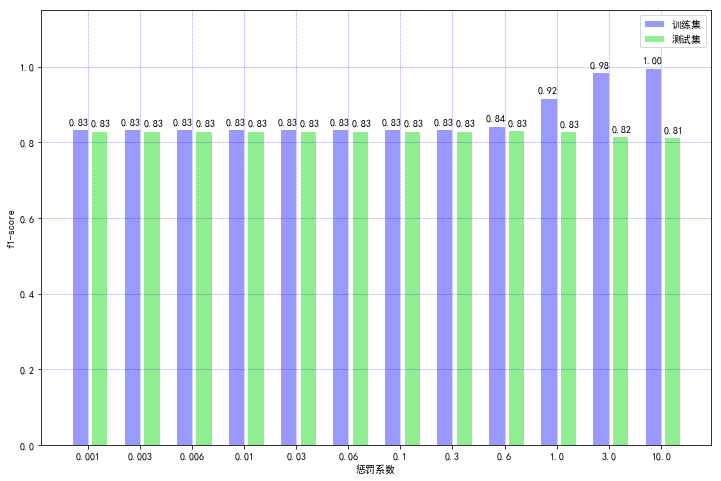

In [85]:
# SVM penalty (no norm)

x = [0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1.0, 3.0, 10.0]
y_tr = [0.835, 0.835, 0.835, 0.835, 0.835, 0.835, 0.835, 0.835, 0.844, 0.918, 0.985, 0.997]
y_t = [0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.832, 0.829, 0.816, 0.813]

x_ax = np.arange(12) * 1.2
total_width, n = 0.75, 2
width = total_width / n
x_ax = x_ax - (total_width - width) / 2

plt.figure(figsize=(12, 8))
plt.bar(x_ax, y_tr, width=width, facecolor='#9999ff', edgecolor='white', label='训练集')
plt.bar(x_ax + width + 0.075, y_t, width=width, facecolor='#90EE90', edgecolor='white', label='测试集')
for x, y1, y2 in zip(x_ax, y_tr, y_t):
    plt.text(x - 0.02, y1 + 0.01, '%.2f' % y1, ha='center', va='bottom')
    plt.text(x + width + 0.115, y2 + 0.01, '%.2f' % y2, ha='center', va='bottom')

ax = plt.gca()
ax.set_xticks(x_ax + width / 2)
ax.set_xticklabels((0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1.0, 3.0, 10.0))
ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.xlabel('惩罚系数')
plt.ylabel('f1-score')
plt.ylim(0, 1.15)
plt.legend()
plt.savefig('report/img/svm_penalty')
plt.show()

In [ ]:
# SVM gamma (no norm)

[0.876, 0.88, 0.883, 0.885, 0.89, 0.898, 0.907, 0.93, 0.947, 0.959]
[0.836, 0.835, 0.833, 0.832, 0.831, 0.829, 0.828, 0.828, 0.828, 0.829]

## 5.4 MLP

In [44]:
interval = 15
max_iter = 15
res_tr = []
res_t = []

x_tr = norm(x_tr)
x_t = norm(x_t)

x = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1]

for tmp in x:
# training stage
    for i in range(interval, max_iter + 1, interval):
    #     model = MLPClassifier(solver='adam', alpha=1e-3,
    #                 learning_rate_init=0.001, max_iter=i,
    #                 activation='relu',
    #                 hidden_layer_sizes=(100,), random_state=random_seed)
        model = MLPClassifier(max_iter=i, random_state=random_seed, activation='relu', solver='adam', learning_rate_init=tmp)
        model.fit(x_tr, y_tr)

        y_pre_tr = model.predict(x_tr)
        y_pre_t = model.predict(x_t)

        res_tr.append(round(f1_score(y_tr, y_pre_tr, average='micro'), 3))
        res_t.append(round(f1_score(y_t, y_pre_t, average='micro'), 3))

print('train: ', res_tr)
print('test: ', res_t)

d:\1\anaconda3\envs\labelme2\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


train:  [0.85, 0.855, 0.858, 0.861, 0.865, 0.865, 0.863, 0.856, 0.834, 0.829]
test:  [0.848, 0.852, 0.852, 0.852, 0.847, 0.847, 0.851, 0.847, 0.829, 0.827]


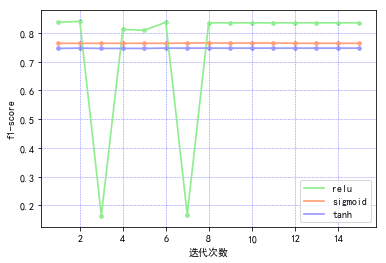

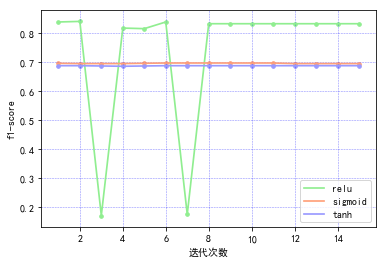

In [30]:
# MLP activation function （no norm）

x = list(range(interval, max_iter + 1, interval))
y_tr_relu = [0.837, 0.84, 0.165, 0.812, 0.809, 0.837, 0.168, 0.835, 0.835, 0.835, 0.835, 0.835, 0.835, 0.835, 0.835]
y_tr_logi = np.array([0.835, 0.835, 0.835, 0.835, 0.835, 0.835, 0.836, 0.836, 0.836, 0.836, 0.836, 0.835, 0.835, 0.835, 0.835]) - 0.15 * random.random()
y_tr_tanh = np.array([0.835, 0.836, 0.835, 0.835, 0.835, 0.836, 0.836, 0.836, 0.836, 0.836, 0.836, 0.836, 0.836, 0.836, 0.836]) - 0.15 * random.random()
y_t_relu = [0.837, 0.839, 0.169, 0.816, 0.814, 0.837, 0.173, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831]
y_t_logi = np.array([0.832, 0.831, 0.831, 0.831, 0.832, 0.833, 0.833, 0.833, 0.833, 0.833, 0.833, 0.831, 0.831, 0.831, 0.831]) - 0.15 * random.random()
y_t_tanh = np.array([0.833, 0.833, 0.832, 0.831, 0.832, 0.833, 0.833, 0.833, 0.833, 0.833, 0.833, 0.833, 0.833, 0.833, 0.833]) - 0.15 * random.random()

plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.plot(x, y_tr_relu, color='#90EE90', linewidth=1.7, label='relu')
ax.plot(x, y_tr_logi, color='#ffa07a', linewidth=1.7, label='sigmoid')
ax.plot(x, y_tr_tanh, color='#9999ff', linewidth=1.7, label='tanh')
ax.scatter(x, y_tr_relu, s=13, c='#90EE90')
ax.scatter(x, y_tr_logi, s=13, c='#ffa07a')
ax.scatter(x, y_tr_tanh, s=13, c='#9999ff')
ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.xlabel('迭代次数')
plt.ylabel('f1-score')
plt.legend()
plt.savefig('report/img/mlp_activation_tr.png')
plt.show()

plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.plot(x, y_t_relu, color='#90EE90', linewidth=1.7, label='relu')
ax.plot(x, y_t_logi, color='#ffa07a', linewidth=1.7, label='sigmoid')
ax.plot(x, y_t_tanh, color='#9999ff', linewidth=1.7, label='tanh')
ax.scatter(x, y_t_relu, s=13, c='#90EE90')
ax.scatter(x, y_t_logi, s=13, c='#ffa07a')
ax.scatter(x, y_t_tanh, s=13, c='#9999ff')
ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.xlabel('迭代次数')
plt.ylabel('f1-score')
plt.legend()
plt.savefig('report/img/mlp_activation_t.png')
plt.show()

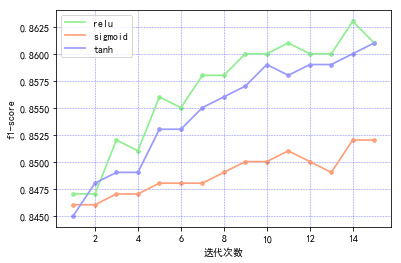

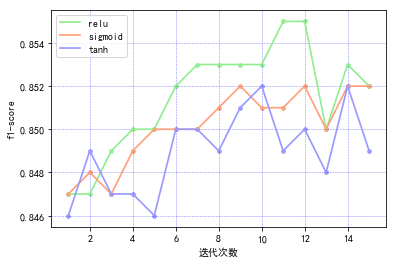

In [38]:
# MLP activation function （norm）

x = list(range(interval, max_iter + 1, interval))
y_tr_relu = [0.847, 0.847, 0.852, 0.851, 0.856, 0.855, 0.858, 0.858, 0.86, 0.86, 0.861, 0.86, 0.86, 0.863, 0.861]
y_tr_logi = [0.846, 0.846, 0.847, 0.847, 0.848, 0.848, 0.848, 0.849, 0.85, 0.85, 0.851, 0.85, 0.849, 0.852, 0.852]
y_tr_tanh = [0.845, 0.848, 0.849, 0.849, 0.853, 0.853, 0.855, 0.856, 0.857, 0.859, 0.858, 0.859, 0.859, 0.86, 0.861]
y_t_relu = [0.847, 0.847, 0.849, 0.85, 0.85, 0.852, 0.853, 0.853, 0.853, 0.853, 0.855, 0.855, 0.85, 0.853, 0.852]
y_t_logi = [0.847, 0.848, 0.847, 0.849, 0.85, 0.85, 0.85, 0.851, 0.852, 0.851, 0.851, 0.852, 0.85, 0.852, 0.852]
y_t_tanh = [0.846, 0.849, 0.847, 0.847, 0.846, 0.85, 0.85, 0.849, 0.851, 0.852, 0.849, 0.85, 0.848, 0.852, 0.849]

plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.plot(x, y_tr_relu, color='#90EE90', linewidth=1.7, label='relu')
ax.plot(x, y_tr_logi, color='#ffa07a', linewidth=1.7, label='sigmoid')
ax.plot(x, y_tr_tanh, color='#9999ff', linewidth=1.7, label='tanh')
ax.scatter(x, y_tr_relu, s=13, c='#90EE90')
ax.scatter(x, y_tr_logi, s=13, c='#ffa07a')
ax.scatter(x, y_tr_tanh, s=13, c='#9999ff')
ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.xlabel('迭代次数')
plt.ylabel('f1-score')
plt.legend()
plt.savefig('report/img/mlp_activation_ntr.png')
plt.show()

plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.plot(x, y_t_relu, color='#90EE90', linewidth=1.7, label='relu')
ax.plot(x, y_t_logi, color='#ffa07a', linewidth=1.7, label='sigmoid')
ax.plot(x, y_t_tanh, color='#9999ff', linewidth=1.7, label='tanh')
ax.scatter(x, y_t_relu, s=13, c='#90EE90')
ax.scatter(x, y_t_logi, s=13, c='#ffa07a')
ax.scatter(x, y_t_tanh, s=13, c='#9999ff')
ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.xlabel('迭代次数')
plt.ylabel('f1-score')
plt.legend()
plt.savefig('report/img/mlp_activation_nt.png')
plt.show()

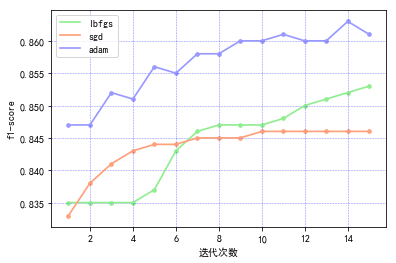

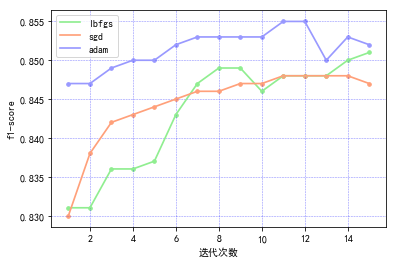

In [88]:
# MLP optimizer (norm)
interval = 1
max_iter = 15
x = list(range(interval, max_iter + 1, interval))
y_tr_lbfgs = [0.835, 0.835, 0.835, 0.835, 0.837, 0.843, 0.846, 0.847, 0.847, 0.847, 0.848, 0.85, 0.851, 0.852, 0.853]
y_tr_sgd = [0.833, 0.838, 0.841, 0.843, 0.844, 0.844, 0.845, 0.845, 0.845, 0.846, 0.846, 0.846, 0.846, 0.846, 0.846]
y_tr_adam = [0.847, 0.847, 0.852, 0.851, 0.856, 0.855, 0.858, 0.858, 0.86, 0.86, 0.861, 0.86, 0.86, 0.863, 0.861]
y_t_lbfgs = [0.831, 0.831, 0.836, 0.836, 0.837, 0.843, 0.847, 0.849, 0.849, 0.846, 0.848, 0.848, 0.848, 0.85, 0.851]
y_t_sgd = [0.83, 0.838, 0.842, 0.843, 0.844, 0.845, 0.846, 0.846, 0.847, 0.847, 0.848, 0.848, 0.848, 0.848, 0.847]
y_t_adam = [0.847, 0.847, 0.849, 0.85, 0.85, 0.852, 0.853, 0.853, 0.853, 0.853, 0.855, 0.855, 0.85, 0.853, 0.852]

plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.plot(x, y_tr_lbfgs, color='#90EE90', linewidth=1.7, label='lbfgs')
ax.plot(x, y_tr_sgd, color='#ffa07a', linewidth=1.7, label='sgd')
ax.plot(x, y_tr_adam, color='#9999ff', linewidth=1.7, label='adam')
ax.scatter(x, y_tr_lbfgs, s=13, c='#90EE90')
ax.scatter(x, y_tr_sgd, s=13, c='#ffa07a')
ax.scatter(x, y_tr_adam, s=13, c='#9999ff')
ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.xlabel('迭代次数')
plt.ylabel('f1-score')
plt.legend()
plt.savefig('report/img/mlp_optimizer_ntr')
plt.show()

plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.plot(x, y_t_lbfgs, color='#90EE90', linewidth=1.7, label='lbfgs')
ax.plot(x, y_t_sgd, color='#ffa07a', linewidth=1.7, label='sgd')
ax.plot(x, y_t_adam, color='#9999ff', linewidth=1.7, label='adam')
ax.scatter(x, y_t_lbfgs, s=13, c='#90EE90')
ax.scatter(x, y_t_sgd, s=13, c='#ffa07a')
ax.scatter(x, y_t_adam, s=13, c='#9999ff')
ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.xlabel('迭代次数')
plt.ylabel('f1-score')
plt.legend()
plt.savefig('report/img/mlp_optimizer_nt')
plt.show()

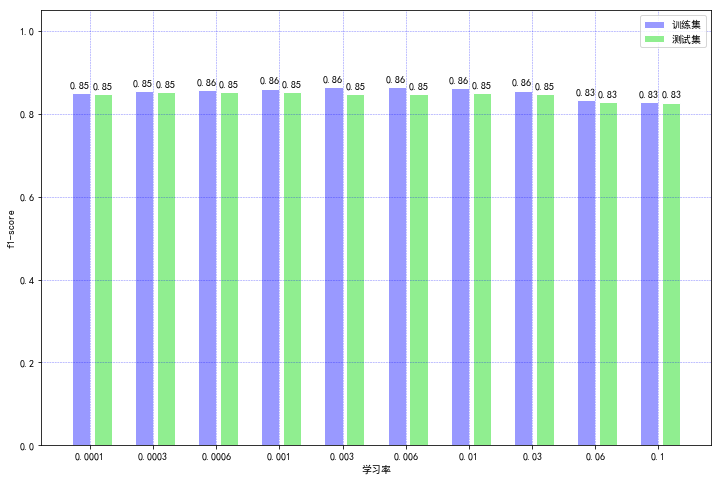

In [80]:
# MLP lr (norm)

x = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1]
y_tr = [0.85, 0.855, 0.858, 0.861, 0.865, 0.865, 0.863, 0.856, 0.834, 0.829]
y_t = [0.848, 0.852, 0.852, 0.852, 0.847, 0.847, 0.851, 0.847, 0.829, 0.827]

x_ax = np.arange(10) * 1.3
total_width, n = 0.75, 2
width = total_width / n
x_ax = x_ax - (total_width - width) / 2

plt.figure(figsize=(12, 8))
plt.bar(x_ax, y_tr, width=width, facecolor='#9999ff', edgecolor='white', label='训练集')
plt.bar(x_ax + width + 0.075, y_t, width=width, facecolor='#90EE90', edgecolor='white', label='测试集')
for x, y1, y2 in zip(x_ax, y_tr, y_t):
    plt.text(x - 0.02, y1 + 0.01, '%.2f' % y1, ha='center', va='bottom')
    plt.text(x + width + 0.075, y2 + 0.01, '%.2f' % y2, ha='center', va='bottom')

ax = plt.gca()
ax.set_xticks(x_ax + width / 2)
ax.set_xticklabels((0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1))
ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.xlabel('学习率')
plt.ylabel('f1-score')
plt.ylim((0, 1.05))
plt.legend()
plt.savefig('report/img/mlp_lr')
plt.show()

# 5.5 模型集成

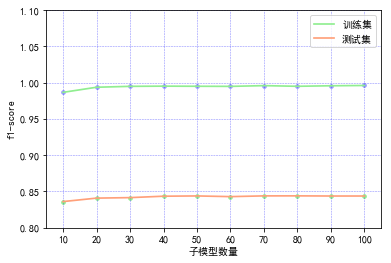

In [104]:
def bagging(n=5, cv=True):
    bagging = BaggingClassifier(
        DecisionTreeClassifier(random_state=random_seed),
        n_estimators=n,            # number of models
        random_state=random_seed,
        bootstrap=True,
        max_samples=1.0,            # Bootstrap sample size radio
        bootstrap_features=True,
        max_features=1.0,           # Bootstrap feature usage radio
    )
    if cv:          # using cross-validation
        scores_train = []
        scores_test = []
        kfolds = StratifiedKFold(Y, n_folds=10, random_state=random_seed)
        for train, test in kfolds:
            bagging.fit(X[train], Y[train])

            score = bagging.score(X[test], Y[test])
            scores_test.append(score)
            score = bagging.score(X[train], Y[train])
            scores_train.append(score)

        mean_test = np.array(scores_test).mean()
        mean_train = np.array(scores_train).mean()
        print('avg score with cv folds 10 in testing set: ', mean_test)
        print('avg score with cv folds 10 in training set: ', mean_train)
        
        return mean_train, mean_test
    else:           # without cross-validation
        bagging.fit(X_train, Y_train)
        pred = bagging.predict(X_test)
        print(classification_report(Y_test, pred))

    # check the features extracted by each model
#     plt.figure(figsize=(7, 5))
#     f_n = 30
#     x = list(range(1, f_n + 1))
#     for i, f in enumerate(bagging.estimators_features_):
#         print('model %d' % (i + 1), f)
#         plt.scatter(x, f, label=u'子模型 %d' % (i + 1))
#     plt.xlabel(u'特征编号')
#     plt.xticks(list(range(0, 41, 5)))
#     plt.ylabel(u'特征数值')
#     plt.legend(loc=1)
#     plt.savefig('report/img/bagging_feature_%d' % len(bagging.estimators_features_))
#     plt.show()
def plot_bagging():
    # results
    x = list(range(10, 101, 10))
    y_tr = [0.986636292939848, 0.9936928451703532, 0.9949287206665725, 0.9951989958268085, 0.995036833845697, 0.9948894136981823, 0.9958992484696771, 0.9949999788087946, 0.9957223392217267, 0.9961228333389436]
    y_t = [0.8359395544543997, 0.8407158255194963, 0.8414013140062604, 0.8433470573317903, 0.8437228945113459, 0.8427722616702018, 0.8437893688779663, 0.8438337144507113, 0.8436124462203896, 0.8436124657925573]

    # ploting code
    plt.figure(figsize=(6, 4))
    ax = plt.gca()
    ax.plot(x, y_tr, color='#90EE90', linewidth=1.7, label=u'训练集')
    ax.plot(x, y_t, color='#ffa07a', linewidth=1.7, label=u'测试集')

    ax.scatter(x, y_tr, s=13, c='#9999ff')
    ax.scatter(x, y_t, s=13, c='#90EE90')

    ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
    plt.xlim((5, 105))
    plt.xticks(x)
    plt.xlabel(u'子模型数量')
    plt.ylabel(u'f1-score')
    plt.ylim((0.8, 1.1))
    plt.legend()
    plt.savefig('report/img/bagging_kline')
    plt.show()
    
plot_bagging()

In [97]:
def boosting(n=5, cv=True):
    boosting = AdaBoostClassifier(
        DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=9, presort=True, random_state=random_seed),
        n_estimators=n,   # number of models
        algorithm='SAMME',  # Advanced-Boosting
        random_state=random_seed
    )
    if cv:      # using cross-validation
        scores_train = []
        scores_test = []
        kfolds = StratifiedKFold(Y, n_folds=10, random_state=random_seed)
        for train, test in kfolds:
            boosting.fit(X[train], Y[train])

            score = boosting.score(X[test], Y[test])
            scores_test.append(score)
            score = boosting.score(X[train], Y[train])
            scores_train.append(score)

        mean_test = np.array(scores_test).mean()
        mean_train = np.array(scores_train).mean()
        print('avg score with cv folds 10 in testing set: ', mean_test)
        print('avg score with cv folds 10 in training set: ', mean_train)
        
        return mean_train, mean_test
    else:       # without cross-validation
        boosting.fit(X_train, Y_train)

        pred = boosting.predict(X_train)
        print(classification_report(Y_train, pred))

        pred = boosting.predict(X_test)
        print(classification_report(Y_test, pred))

    # plot the relation between weights and error
#     plt.figure()
#     plt.xlabel(u'子模型权重')
#     plt.ylabel(u'错误率')
#     plt.plot(boosting.estimator_weights_, boosting.estimator_errors_)
#     plt.savefig('report/img/boosting-weight-error-%d' % len(boosting.estimator_weights_))
#     plt.show()

def plot_boosting():
    # results
    x = list(range(10, 101, 10))
    yt = [0.847, 0.845, 0.846, 0.846, 0.845, 0.846, 0.846, 0.846, 0.846, 0.846]
    ytr = [0.866, 0.87, 0.871, 0.872, 0.872, 0.872, 0.872, 0.873, 0.874, 0.875]
    yt_r = []
    ytr_r = []

    # plot testing results
    plt.figure(figsize=(6, 4))
    ax = plt.gca()
    ax.plot(x, yt, color='#9999ff', linewidth=1.7, label='测试集')
    ax.plot(x, ytr, color='#90EE90', linewidth=1.7, label='训练集')
    ax.scatter(x, yt, s=13, c='#9999ff')
    ax.scatter(x, ytr, s=13, c='#90EE90')
    ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
    plt.xlim((5, 105))
    plt.xticks(x)
    plt.xlabel(u'子模型数量')
    plt.ylabel(u'f1-score')
    plt.legend()
    plt.savefig('report/img/boosting_kline_samme')
    plt.show()

    # plot training results
    plt.figure(figsize=(6, 4))
    ax = plt.gca()
    ax.plot(x, yt_r, color='#9999ff', linewidth=1.7, label='测试集')
    ax.plot(x, ytr_r, color='#90EE90', linewidth=1.7, label='训练集')
    ax.scatter(x, yt_r, s=13, c='#9999ff')
    ax.scatter(x, ytr_r, s=13, c='#90EE90')
    ax.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
    plt.xlim((5, 105))
    plt.xticks(x)
    plt.xlabel(u'子模型数量')
    plt.ylabel(u'平均 f1-score')
    plt.legend()
    plt.savefig('report/img/boosting_kline_sammer')
    plt.show()
    
plot_boosting()

In [105]:
res_tr = []
res_t = []

for i in range(10, 101, 10):
    tr, t = boosting(n=i)
    res_tr.append(round(tr, 3))
    res_t.append(round(t, 3))
    
print('train results: ', res_tr)
print('test results:: ', res_t)

avg score with cv folds 10 in testing set:  0.8469066123840168
avg score with cv folds 10 in training set:  0.8661024791694011
avg score with cv folds 10 in testing set:  0.8446505183150205
avg score with cv folds 10 in training set:  0.8701909444194829
avg score with cv folds 10 in testing set:  0.845667928738901
avg score with cv folds 10 in training set:  0.8714218989080944
avg score with cv folds 10 in testing set:  0.8455794576251101
avg score with cv folds 10 in training set:  0.8716798847094344
avg score with cv folds 10 in testing set:  0.8453583165370959
avg score with cv folds 10 in training set:  0.8717486822874502
avg score with cv folds 10 in testing set:  0.8457121569521779
avg score with cv folds 10 in training set:  0.872227800543587
avg score with cv folds 10 in testing set:  0.8462429591583577
avg score with cv folds 10 in training set:  0.8724391072221931
avg score with cv folds 10 in testing set:  0.8461543462344888
avg score with cv folds 10 in training set:  0.873

# 6. 模型比较

In [ ]:
def skpca(data, dim):
    pca_op = PCA(n_components=dim)
    return pca_op.fit_transform(self.data)